---
We'll use tensorflow to predict the number of shapes in each image.

First let's get the pixel data, saving it as `.npy` files in `greyscale-data`

---

In [9]:
import os
import numpy as np
import png


input_directory = 'greyscaled-images'
output_directory = 'greyscaled-data'
if not os.path.exists(output_directory):
  os.makedirs(output_directory)

for filename in os.listdir(input_directory):
  path = os.path.join(input_directory, filename)
  with open(path, 'rb') as image_file:
    reader = png.Reader(file=image_file)
    _, _, pixels, _ = reader.asDirect()
    data = np.array([x / 255. for row in pixels for x in row])
  output_filename = '%s.npy' % filename.split('.')[0]
  output_path = os.path.join(output_directory, output_filename)
  np.save(output_path, data)

---
Load data into various structures for later.  This cell mainly splits the data into training, validation and test folds.  To make the splits I'm hashing filenames and then sorting those hashes alphabetically -- this mixes up the images, but makes the mixing deterministic.

---

In [30]:
import hashlib


input_directory = 'greyscaled-data'

# Load all the data into an array.
# Each element is a tuple: (filename, numpy data).
# The filename structure is "<number>-<color>-<texture>-<shape>-<rotation>.png"
all_data = [
  (f, np.load(os.path.join(input_directory, f))) for f in os.listdir(input_directory)
]

# Hash the filename and sort the hashes alphabetically.
all_data_with_hashes = [
  (filename, hashlib.md5(filename).hexdigest(), data) for filename, data in all_data
]
all_data_sorted = sorted(all_data_with_hashes, key=lambda element: element[1])

# Save 20% of the data for testing (the final, one-shot evaluation of performance).
split_index = int(0.2 * len(all_data_sorted))
test_data = all_data_sorted[0:split_index]
remaining_data = all_data_sorted[split_index:]

# Now save 20% of the remaining data for validation.
split_index = int(0.2 * len(remaining_data))
validation_data = remaining_data[0:split_index]
training_data = remaining_data[split_index:]

# For convenience, get all the pixel data into separate arrays.
training_pixel_data = [pixel_data for _, _, pixel_data in training_data]
validation_pixel_data = np.array([pixel_data for _, _, pixel_data in validation_data])
test_pixel_data = np.array([pixel_data for _, _, pixel_data in test_data])

# Each filename, in its text, has an embedded "number of shapes."
# We need to convert those classes (the output ground truth) into category arrays.
possible_categories = [
    [1., 0., 0.],
    [0., 1., 0.],
    [0., 0., 1.],
]
training_output_categories = [
  possible_categories[int(filename.split('-')[0]) - 1] for filename, _, _ in training_data
]
validation_output_categories = [
  possible_categories[int(filename.split('-')[0]) - 1] for filename, _, _ in validation_data
]
test_output_categories = [
  possible_categories[int(filename.split('-')[0]) - 1] for filename, _, _ in test_data
]

---
setup tensorflow

---

In [32]:
import random
import tensorflow as tf


learning_rate = 1e-6
card_width, card_height = 150, 150

# Setup the training steps.
tf_training_data = tf.placeholder(tf.float32, shape=[None, card_width*card_height])
tf_training_labels = tf.placeholder(tf.float32, shape=[None, 3])

#input_pixel_data = tf.placeholder(tf.float32, shape=[None, card_width*card_height])
weights = tf.Variable(tf.zeros([card_width*card_height, 3]))
biases = tf.Variable(tf.zeros([3]))
estimated_output_category_in_training = tf.nn.softmax(tf.matmul(tf_training_data, weights) + biases)
#actual_output_category = tf.placeholder(tf.float32, [None, 3])

cross_entropy = -tf.reduce_sum(tf_training_labels * tf.log(estimated_output_category_in_training))
training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)


def calculate_accuracy(predictions, ground_truth):
  """Determine what proportion of predictions are accurate based on ground truth."""
  correctness = tf.equal(tf.argmax(predictions, 1), tf.argmax(ground_truth, 1))
  return tf.reduce_mean(tf.cast(correctness, tf.float32))


# Setup validation.  We have to reshape to a "dense tensor"
# by, essentially, combining this array of arrays into a true matrix.
tf_validation_pixel_data = tf.constant(
  validation_pixel_data.reshape((-1, card_width*card_height)).astype(np.float32))
estimated_output_category_in_validation = tf.nn.softmax(tf.matmul(tf_validation_pixel_data, weights) + biases)
validation_accuracy = calculate_accuracy(estimated_output_category_in_validation, validation_output_categories)

# Setup the final test run.
tf_test_data = tf.constant(
  test_pixel_data.reshape((-1, card_width*card_height)).astype(np.float32))

'''
correct_prediction = tf.equal(
  tf.argmax(estimated_output_category, 1), 
  tf.argmax(actual_output_category, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
'''

'\ncorrect_prediction = tf.equal(\n  tf.argmax(estimated_output_category, 1), \n  tf.argmax(actual_output_category, 1))\naccuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))\n'

---
and run the optimizer in batches

---

In [35]:
validation_accuracies = []
total_iterations = 1000
batch_size = 100

session = tf.Session()
session.run(tf.initialize_all_variables())

for iteration in range(total_iterations):
  batch_data = random.sample(training_data, batch_size)
  batch_input_pixel_data = [pixel_data for _, _, pixel_data in batch_data]
  batch_output_categories = [
    possible_categories[int(filename.split('-')[0]) - 1] for filename, _, _ in batch_data
  ]
  batch_training_data = {
    tf_training_data: batch_input_pixel_data,
    tf_training_labels: batch_output_categories,
  }
  
  session.run(training_step, feed_dict=batch_training_data)
  
  if (iteration % 50) == 0:
    validation_input_data = {
      tf_training_data: validation_pixel_data,
      tf_training_labels: validation_output_categories,
    }
    accuracy = session.run(accuracy, feed_dict=validation_input_data)
    validation_accuracies.append((iteration, accuracy))
    if (iteration % 100) == 0:
      print 'iteration: %s -> accuracy: %s' % (iteration, measured_accuracy)

print 'done.'

InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_2' with dtype float
	 [[Node: Placeholder_2 = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]
Caused by op u'Placeholder_2', defined at:
  File "/usr/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/matt/conf/venvs/setbot/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/matt/conf/venvs/setbot/local/lib/python2.7/site-packages/traitlets/config/application.py", line 589, in launch_instance
    app.start()
  File "/home/matt/conf/venvs/setbot/local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 442, in start
    ioloop.IOLoop.instance().start()
  File "/home/matt/conf/venvs/setbot/local/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/matt/conf/venvs/setbot/local/lib/python2.7/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/home/matt/conf/venvs/setbot/local/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/matt/conf/venvs/setbot/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/matt/conf/venvs/setbot/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/matt/conf/venvs/setbot/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/matt/conf/venvs/setbot/local/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/matt/conf/venvs/setbot/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/matt/conf/venvs/setbot/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/matt/conf/venvs/setbot/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "/home/matt/conf/venvs/setbot/local/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/matt/conf/venvs/setbot/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/matt/conf/venvs/setbot/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2825, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/matt/conf/venvs/setbot/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-95ad47ecd1ae>", line 8, in <module>
    input_pixel_data = tf.placeholder(tf.float32, shape=[None, card_width*card_height])
  File "/home/matt/conf/venvs/setbot/local/lib/python2.7/site-packages/tensorflow/python/ops/array_ops.py", line 742, in placeholder
    name=name)
  File "/home/matt/conf/venvs/setbot/local/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 583, in _placeholder
    name=name)
  File "/home/matt/conf/venvs/setbot/local/lib/python2.7/site-packages/tensorflow/python/ops/op_def_library.py", line 655, in apply_op
    op_def=op_def)
  File "/home/matt/conf/venvs/setbot/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2040, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/matt/conf/venvs/setbot/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1087, in __init__
    self._traceback = _extract_stack()


---
plot the accuracy vs iteration number

---

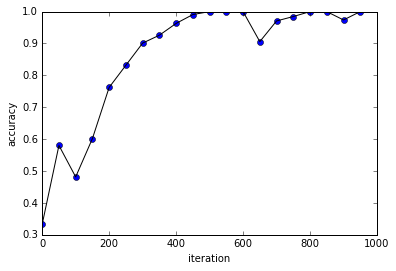

In [6]:
% matplotlib inline
import matplotlib.pyplot as plt

plt.plot(measured_iterations, measured_accuracies, 'bo')
plt.plot(measured_iterations, measured_accuracies, 'k-')
_ = plt.xlabel('iteration')
_ = plt.ylabel('accuracy')